<a href="https://colab.research.google.com/github/Slautin/2025_vae_dkl/blob/main/2_DKL_VAE_card_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VAE model: card dataset

February 2025

Supporting codes for the manuscript: **Integrating Predictive and Generative Capabilities by Latent Space Design via the DKL-VAE model**

*Notebook 2 of 3*

This Notebook presents an analysis of the latent space structure learned by a DKL-VAE model trained on both the complete card suit dataset and a subset of it.

* Author [Boris Slautin](https://scholar.google.com/citations?hl=ru&view_op=list_works&gmla=AH70aAU_JtxEIQgg_RTLPnUSZHKp1J1iDrJUxTZ7Dzw5p5jEtCEug5zMWLCh4A-pe5ekW_9a_aXHOSIjEp-2UT_kypL9DfD7GcD76qEpeOzSkAibBjmm_7RL&user=Y2AXABsAAAAJ)

* [Pyroved](https://pyroved.readthedocs.io/en/latest/) package by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)

* DKL-VAE model realization and tuning by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en), [Utkarsh Pratiush](https://scholar.google.com/citations?user=BqhnGGAAAAAJ&hl=en), [Boris Slautin](https://scholar.google.com/citations?hl=ru&view_op=list_works&gmla=AH70aAU_JtxEIQgg_RTLPnUSZHKp1J1iDrJUxTZ7Dzw5p5jEtCEug5zMWLCh4A-pe5ekW_9a_aXHOSIjEp-2UT_kypL9DfD7GcD76qEpeOzSkAibBjmm_7RL&user=Y2AXABsAAAAJ)

* Project lead and supervision by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)


In [1]:
!pip install git+https://github.com/ziatdinovmax/pyroved.git;
!pip install -q kornia;

  Cloning https://github.com/ziatdinovmax/pyroved.git to /tmp/pip-req-build-ekvs319o
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/pyroved.git /tmp/pip-req-build-ekvs319o
  Resolved https://github.com/ziatdinovmax/pyroved.git to commit 7807ffb1cb415b3cc76c1e02d52465a8ae0eeae4
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.2 MB/s eta 0:00:00
 

In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import kornia as K
from skimage.metrics import structural_similarity as ssim

from pyroved.models.base import baseVAE
from pyroved.utils import (set_deterministic_mode, init_dataloader, get_sampler,
                           generate_latent_grid, plot_img_grid, plot_spect_grid)

from pyroved.nets import fcEncoderNet, fcDecoderNet, sDecoderNet

from typing import Callable, Dict, Union, List, Tuple, Optional, Tuple, Type
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import pyro.infer as infer

import torch
import torch.nn as nn

tt = torch.tensor

In [3]:
#@title arbitrary functions
resize = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = resize(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = resize(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = resize(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = resize(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4

def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1, card2, card3, card4 = cards[0], cards[1], cards[2], cards[3]

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears

def rearrange_manifold(dat):
  grid_size = int(np.sqrt(dat.shape[0]))  # 10 x 10 grid for 100 slices
  rows = grid_size * dat.shape[1]  # 10 * 48 = 480
  cols = grid_size * dat.shape[2]  # 10 * 48 = 480

  # Rearrange into 2D grid
  rearranged = (dat.reshape(grid_size, grid_size, dat.shape[1], dat.shape[2])
                .flip(0)
                .flip(1)
                .permute(1, 2, 0, 3)  # Rearrange axes for proper stacking
                .reshape(rows, cols)
                )  # Combine into 2D array

  # Convert to NumPy array
  rearranged_np = rearranged.numpy()
  return rearranged_np

# 1. VAE-DKL model

In [4]:
#@title Kernels

kernel_fn_type = Callable[[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor], torch.Tensor],  torch.Tensor]

get_device = lambda: 'cuda:0' if torch.cuda.is_available() else 'cpu'

def _sqrt(x, eps=1e-12):
    return torch.sqrt(x + eps)


def add_jitter(x, jitter=1e-6):
    return x + jitter

def square_scaled_distance(X: torch.tensor, Z: torch.Tensor,
                           lengthscale: torch.Tensor = 1.,
                           **kwargs: str
                           ) -> torch.Tensor:

    device = kwargs.get("device", get_device())
    scaled_X = X / lengthscale.to(device)
    scaled_Z = Z / lengthscale.to(device)
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = torch.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)


def RBFKernel(X: torch.Tensor, Z: torch.Tensor,
              params: Dict[str, torch.Tensor],
              noise: int = 0, **kwargs: Union[float, str]
              ) -> torch.Tensor:

    device = kwargs.get("device", get_device())
    r2 = square_scaled_distance(X, Z, params["k_length"])
    k = params["k_scale"] * torch.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += (add_jitter(noise, **kwargs) * torch.eye(X.shape[0])).to(device)
    return k


def Matern52Kernel(X: torch.Tensor, Z: torch.Tensor,
                   params: Dict[str, torch.Tensor],
                   noise: int = 0, **kwargs: Union[float, str]
                   ) -> torch.Tensor:

    device = kwargs.get("device", get_device())
    r2 = square_scaled_distance(X, Z, params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = params["k_scale"] * (1 + sqrt5_r + (5/3) * r2) * torch.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += (add_jitter(noise, **kwargs) * torch.eye(X.shape[0])).to(device)
    return k


def get_kernel(kernel: Union[str, kernel_fn_type] = 'RBF'):
    kernel_book = {
        'RBF': RBFKernel,
        'Matern': Matern52Kernel,
    }
    if isinstance(kernel, str):
        try:
            kernel = kernel_book[kernel]
        except KeyError:
            print('Select one of the currently available kernels:',
                  *kernel_book.keys())
            raise
    return kernel



In [5]:
#@title VAE-DKL model

class dkiVAE(baseVAE):

    def __init__(self,
                 data_dim: Tuple[int],
                 latent_dim: int,
                 invariances: List[str] = None,
                 hidden_dim_e: List[int] = None,
                 hidden_dim_d: List[int] = None,
                 activation: str = "tanh",
                 sampler_d: str = "bernoulli",
                 sigmoid_d: bool = True,
                 kernel: kernel_fn_type = 'RBF',
                 latent_mean_fn: Optional[Callable[[torch.Tensor, Dict[str, torch.Tensor]], torch.Tensor]] = None,
                 latent_mean_fn_prior: Optional[Callable[[torch.Tensor], Dict[str, torch.Tensor]]] = None,
                 dkl_scale_factor: int = 1,
                 X: torch.Tensor = None,
                 y: torch.Tensor = None,
                 seed: int = 1,
                 rng_key = None,
                 **kwargs: Union[str, float]
                 ) -> None:

        args = (data_dim, invariances)
        super(dkiVAE, self).__init__(*args, **kwargs)
        pyro.clear_param_store()
        set_deterministic_mode(seed)

        self.data_dim = data_dim
        self.kernel = kernel
        self.dkl_scale = dkl_scale_factor
        self.latent_mean_fn = latent_mean_fn
        self.latent_mean_fn_prior = latent_mean_fn_prior
        self.rng_key = rng_key

        # Initialize z-Encoder neural network
        self.encoder_z = fcEncoderNet(
            data_dim, latent_dim+self.coord, 0,
            hidden_dim_e, activation, flat=False)

        # Initialize Decoder neural network
        dnet = sDecoderNet if 0 < self.coord < 5 else fcDecoderNet
        self.decoder = dnet(
            data_dim, latent_dim, 0, hidden_dim_d,
            activation, sigmoid_out=sigmoid_d, unflat=False)
        self.sampler_d = get_sampler(sampler_d, **kwargs)

        # Set latent dimensions
        self.z_dim = latent_dim + self.coord

        self.X_train = X
        self.y_train = y

        # Send model parameters to their appropriate devices
        self.to(self.device)

    def set_data(self, X: torch.Tensor, y: torch.Tensor):
        self.X_train = X
        self.y_train = y

    def model(self,
              x: torch.Tensor,
              **kwargs: float) -> None:
        """
        Defines the VAE model p(x|z)p(z)
        """
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        reshape_ = torch.prod(torch.tensor(x.shape[1:])).item()

        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with pyro.poutine.scale(scale=beta):
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


            if self.coord > 0:  # rotationally- and/or translationaly-invariant mode
                # Split latent variable into parts for rotation
                # and/or translation and image content
                phi, dx, sc, z = self.split_latent(z)
                if 't' in self.invariances:
                    dx = (dx * self.t_prior).unsqueeze(1)
                # transform coordinate grid
                grid = self.grid.expand(x.shape[0], *self.grid.shape)
                x_coord_prime = transform_coordinates(grid, phi, dx, sc)
            # decode the latent code z together with the transformed coordinates (if any)
            dec_args = (x_coord_prime, z) if self.coord else (z,)
            loc = self.decoder(*dec_args)
            # score against actual images ("binary cross-entropy loss")
            pyro.sample(
                "obs", self.sampler_d(loc.view(-1, reshape_)).to_event(1),
                obs=x.view(-1, reshape_))


    def guide(self,
               x: torch.Tensor,
               **kwargs: float) -> None:
        """
        Defines the guide q(z|x)
        """
        # register PyTorch module `encoder_z` with Pyro
        pyro.module("encoder_z", self.encoder_z)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)

        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder_z(x)
            # sample the latent code z
            with pyro.poutine.scale(scale=beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def split_latent(self, z: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Split latent variable into parts associated with coordinate transformations
        (rotation and/or transaltion and/or scale) and image content.
        """
        return self._split_latent(z)

    def dkl(self, x: torch.Tensor, y: torch.Tensor, **kwargs) -> None:
        """Defines DKL model"""

        # Encode data using the current state of encoder_z
        z_loc, _ = self.encoder_z(x)


        # # Sample kernel parameters
        kernel_params = self._sample_kernel_params(self.z_dim - self.coord)

        # Sample noise
        noise = pyro.sample("noise", dist.HalfNormal(1.0))
        # GP's mean function
        f_loc = torch.zeros(z_loc.shape[0]).to(self.device)

        if self.latent_mean_fn is not None:
            args = [z_loc]
            if self.latent_mean_fn_prior is not None:
                args += [self.latent_mean_fn_prior()]
            f_loc += self.latent_mean_fn(*args).squeeze()

        # Compute kernel
        k = get_kernel(self.kernel)(
            z_loc, z_loc,
            kernel_params,
            noise,
            **kwargs
        )
        # Sample y according to the standard Gaussian process formula
        with pyro.poutine.scale(scale=self.dkl_scale):
            pyro.sample(
                "y",
                dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
                obs=y,
            )

    def _sample_kernel_params(self, dim: int = None) -> Dict[str, torch.Tensor]:
        """
        Sample kernel parameters with weakly-informative log-normal priors
        """

        with pyro.plate('k_param', dim):  # allows using ARD kernel for kernel_dim > 1
            length = pyro.sample("k_length", dist.Uniform(0.0, 10.))
        scale = pyro.sample("k_scale", dist.Uniform(0.0, 10.))
        kernel_params = {
            "k_length": length, "k_scale": scale}
        return kernel_params

    def encode(self,
               x_new: torch.Tensor,
               **kwargs: int) -> Tuple[torch.Tensor]:
        z = self._encode(x_new, **kwargs)
        z_loc, z_scale = z.split(self.z_dim, 1)
        return z_loc, z_scale

    def decode(self,
               z: torch.Tensor,
               **kwargs: int) -> torch.Tensor:
        z = z.to(self.device)
        loc = self._decode(z, **kwargs)
        return loc

    def get_mvn_posterior(self,
                          z_new: torch.Tensor,
                          noiseless: bool = True,
                          y_residual = None,
                          **kwargs
                          ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns predictive mean and covariance at new latent points
        (mean and cov, where cov.diagonal() is 'uncertainty')
        given a single set of GP parameters
        """

        z_new = z_new.to(self.device)
        z_train = self.encode(self.X_train)[0].to(self.device)
        y_train = self.y_train.to(self.device)

        if y_residual is None:
            y_residual = y_train.clone()

        kernel = get_kernel(self.kernel)
        params_store = pyro.get_param_store()
        self.param_store = params_store
        k_params = {k.split('.')[-1]: v.detach() for (k, v) in params_store.items()
                    if k != "weight" and k != "bias"}

        noise = k_params["noise"]
        self.k_params = k_params
        noise_p = noise * (1 - torch.tensor(noiseless).long())

        # Appply latent mean function
        if self.latent_mean_fn is not None:
            args = [z_train, k_params] if self.latent_mean_fn_prior else [z_train]
            y_residual -= self.latent_mean_fn(*args).squeeze()


        # compute kernel matrices for train and test data
        k_pp = kernel(z_new, z_new, k_params, noise_p, **kwargs)
        k_pX = kernel(z_new, z_train, k_params, jitter=0.0)
        k_XX = kernel(z_train, z_train, k_params, noise, **kwargs)
        # compute the predictive covariance and mean
        K_xx_inv = torch.linalg.inv(k_XX)
        cov = k_pp - torch.matmul(k_pX, torch.matmul(K_xx_inv, k_pX.T))
        mean = torch.matmul(k_pX, torch.matmul(K_xx_inv, y_residual))

        # Apply latent mean function
        if self.latent_mean_fn is not None:
            args = [z_new, k_params] if self.latent_mean_fn_prior else [z_new]
            mean += self.latent_mean_fn(*args).squeeze()

        return mean.cpu(), cov.cpu()

    def dkl_predict(self,
                    X_new: torch.Tensor,
                    noiseless: bool = False,
                    **kwargs
                    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Makes a DKL prediction (input -> encode -> GP -> mean & uncertainty)
        """
        z_new, _ = self.encode(X_new)
        mean, cov = self.get_mvn_posterior(z_new, noiseless, **kwargs)
        return mean, cov.diagonal()

    def manifold2d(self, d: int,
                   plot: bool = True,
                   **kwargs: Union[str, int, float]) -> torch.Tensor:

        z_grid, (grid_x, grid_y) = generate_latent_grid(d, **kwargs)
        loc = self.decode(z_grid, **kwargs)
        if plot:
            if self.ndim == 2:
                loc = loc.reshape(loc.shape[0], *self.data_dim) if loc.ndim < 3 else loc
                plot_img_grid(
                    loc, d,
                    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
                    **kwargs)
            elif self.ndim == 1:
                plot_spect_grid(loc, d, **kwargs)
        return loc


In [6]:
#@title VAE-DKL Trainer

class JointModelTrainer:

    def __init__(self,
                model: Type[nn.Module],
                lr1: float = 1e-4,
                lr2: float = 1e-2,
                optimizer2: Type[pyro.optim.PyroOptim] = None,
                loss_vae: Type[infer.ELBO] = None,
                loss_dkl: Type[infer.ELBO] = None,
                seed: int = 1,
                **kwargs: Union[str, float]
                ) -> None:

        pyro.clear_param_store()
        set_deterministic_mode(seed)
        self.device = kwargs.get(
            "device", 'cuda' if torch.cuda.is_available() else 'cpu')

        optimizer1 = optim.Adam({"lr": lr1})
        optimizer2 = optim.Adam({"lr": lr2})

        loss_vae = infer.Trace_ELBO() if loss_vae is None else loss1
        loss_dkl = infer.Trace_ELBO() if loss_dkl is None else loss2

        self.vae_svi = infer.SVI(
            model.model, model.guide, optimizer1, loss=loss_vae)
        self.dkl_svi = infer.SVI(
            model.dkl, infer.autoguide.AutoDelta(model.dkl),
            optimizer2, loss=loss_dkl)

        self.loss_history = {"training_loss": [], "test_loss": []}
        self.current_epoch = 0
        self.model = model

    def train(self,
              train_loader: Type[torch.utils.data.DataLoader],
              train_vae: bool = True,
              **kwargs: float) -> float:
        """
        Trains a single epoch
        """
        # initialize loss accumulator
        vae_epoch_loss = 0.
        if train_vae:
            # do a training epoch over each mini-batch returned by the data loader
            for data in train_loader:
                x, _ = data
                vae_loss = self.vae_svi.step(x.to(self.device), **kwargs)
                # accumulate loss
                vae_epoch_loss += vae_loss
        vae_epoch_loss /= len(train_loader.dataset)
        # Pass entire data through DKL (exact-gp regime)
        xf, yf = train_loader.dataset.tensors
        dkl_loss = self.dkl_svi.step(
            xf.to(self.device), yf.to(self.device), **kwargs)
        #print(vae_epoch_loss, dkl_loss)
        return vae_epoch_loss + dkl_loss #+

    def step(self,
             train_loader: Type[torch.utils.data.DataLoader],
             train_vae: bool = True,
             **kwargs: float) -> None:
        """
        Single training and (optionally) test step
        Args:
            train_loader:
                Pytorch’s dataloader object with training data
            train_vae:
                Train variational autoencoder at this step
        """
        if self.model.X_train is None or self.model.y_train is None:
            self.model.set_data(*train_loader.dataset.tensors)
        train_loss = self.train(train_loader, train_vae, **kwargs)
        self.loss_history["training_loss"].append(train_loss)
        self.current_epoch += 1

    def print_statistics(self) -> None:
        """
        Prints training and test (if any) losses for current epoch
        """
        e = self.current_epoch
        template = 'Epoch: {} Training loss: {:.4f}'
        print(template.format(e, self.loss_history["training_loss"][-1]))


# 2. Import and Preprocess the Card Suit Dataset

In [7]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

In [8]:
cards = get_data()
cards_all, labels_all, angles_all, translations_all, shears_all = transform_imgs(cards, angle = 30, translation = 0.1, shear = 10, samples = 750)

#3. Train the VAE model on the full dataset

In [9]:
ws = 48
data_dim = (ws, ws)

model = dkiVAE(data_dim, 2, dkl_scale_factor=20)
trainer = JointModelTrainer(model)
dataloader = init_dataloader(cards_all.reshape(-1, ws* ws), angles_all.to(dtype=torch.float32), batch_size=100)

In [10]:
figs = []
for e in range(1500):
    trainer.step(dataloader, train_vae=True)
    trainer.print_statistics()
    # #verbose
    # if (e+1) % 50 == 0:
    #     model.manifold2d(d=12)
    #     z_loc, _ = model.encode(cards_all.reshape(-1, ws* ws))

    #     fig,ax = plt.subplots(1,2, figsize=(10,4))

    #     im = ax[0].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=labels_all, cmap='jet')
    #     cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
    #     im = ax[1].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=angles_all, cmap='jet')
    #     cbar = fig.colorbar(im, ax=ax[1], shrink=.8)

    #     for _ in ax:
    #       _.set_xlabel('$z_1$', fontsize=14)
    #       _.grid()

    #     ax[0].set_title('Suits')
    #     ax[1].set_title('Shears')
    #     ax[0].set_ylabel('$z_2$', fontsize=14)

    #     plt.show()
    #     figs.append(fig)


Epoch: 1 Training loss: 21995527.3274
Epoch: 2 Training loss: 13342807.5490
Epoch: 3 Training loss: 5941501.0152
Epoch: 4 Training loss: 6448267.3326
Epoch: 5 Training loss: 8385733.9148
Epoch: 6 Training loss: 3127376.0605
Epoch: 7 Training loss: 2355493.5065
Epoch: 8 Training loss: 2226455.1006
Epoch: 9 Training loss: 1898898.0116
Epoch: 10 Training loss: 2177608.1198
Epoch: 11 Training loss: 1901314.6324
Epoch: 12 Training loss: 2607855.5752
Epoch: 13 Training loss: 1382833.0990
Epoch: 14 Training loss: 1486161.6678
Epoch: 15 Training loss: 1238210.7301
Epoch: 16 Training loss: 1381086.7998
Epoch: 17 Training loss: 1100896.8087
Epoch: 18 Training loss: 1184392.9256
Epoch: 19 Training loss: 956810.6534
Epoch: 20 Training loss: 1011714.8282
Epoch: 21 Training loss: 850944.2468
Epoch: 22 Training loss: 909678.7266
Epoch: 23 Training loss: 783854.7437
Epoch: 24 Training loss: 858276.5686
Epoch: 25 Training loss: 741688.3239
Epoch: 26 Training loss: 834341.9419
Epoch: 27 Training loss: 7

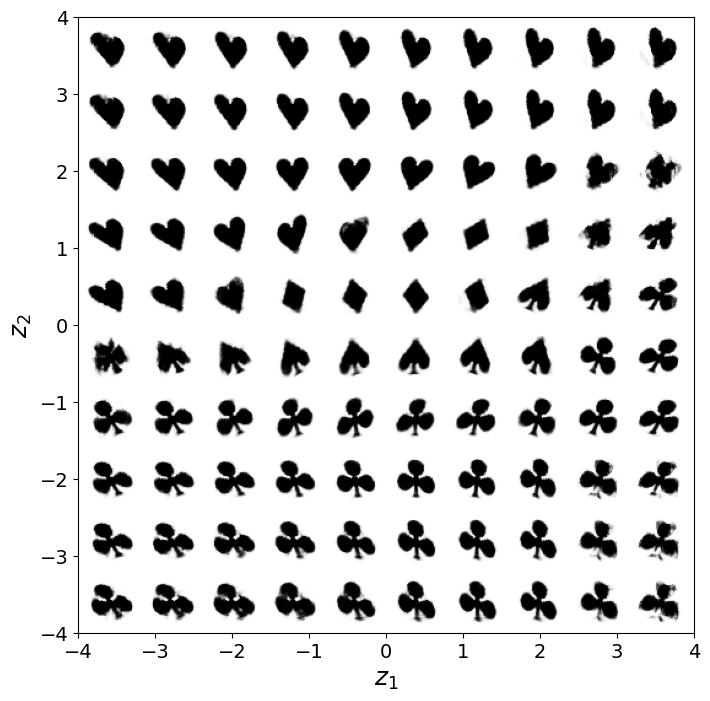

In [11]:
mf = model.manifold2d(d=10, cmap='binary', z_coord=[-4,4,-4,4], dpi=50);
mf_np = rearrange_manifold(mf)

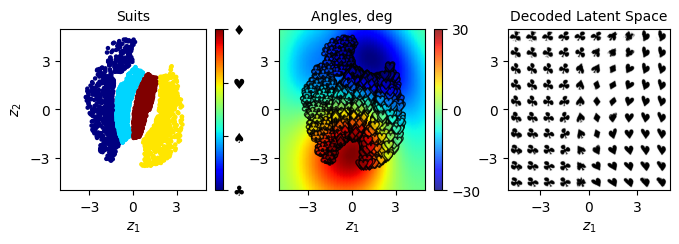

In [12]:
suits = ['♣', '♠', '♥', '♦', ]  # Card suits
suit_markers = {0: '♣', 1: '♠', 2: '♥', 3: '♦'}
z_loc, _ = model.encode(cards_all.reshape(-1, ws* ws))

z_grid, _ = generate_latent_grid(d=100, z_coord=[-5, 5, -5, 5])
mean_m, cov_m = model.get_mvn_posterior(z_grid)

z_loc = z_loc.numpy()

fig,ax = plt.subplots(1,3, figsize=(8,2.1))

im = ax[0].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=labels_all, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_ticks(np.linspace(0, 3, len(suits)))  # Set positions of labels
cbar.set_ticklabels(suits)
ax[0].set_title('Suits', fontsize=10)

ax[1].scatter(z_grid[:, -2], z_grid[:, -1], s=5, c=mean_m, cmap='jet')

for suit_id, suit_marker in suit_markers.items():
  indices = np.where(labels_all == suit_id)
  scatter = ax[1].scatter(z_loc[indices, -2], z_loc[indices, -1],
             label=suit_marker, s=40, alpha=0.8, edgecolors='black',
             marker='$' + suit_marker + '$',
             c = angles_all[indices],
             vmin=-30,
             vmax=30,
             cmap='jet')

cbar = fig.colorbar(scatter, ax=ax[1])
cbar.set_ticks([-30,0,30])
ax[1].set_title('Angles, deg', fontsize=10)

ax[2].imshow(mf_np, cmap='binary', extent = [-5,5,-5,5])
ax[2].set_title('Decoded Latent Space', fontsize=10)

ax[0].set_xlabel('$z_1$', fontsize=10)
ax[1].set_xlabel('$z_1$', fontsize=10)
ax[2].set_xlabel('$z_1$', fontsize=10)
ax[0].set_ylabel('$z_2$', fontsize=10)

for _ in ax:
  _.set_xlim(-5,5)
  _.set_ylim(-5,5)
  _.set_xticks([-3,0,3])
  _.set_yticks([-3,0,3])

#plt.tight_layout()
#fig.savefig('full_dkl_vae.jpg', dpi=300, bbox_inches='tight')

#4. Train the VAE model on the subset

In [13]:
threshold = 0
threshold1 = 15
cards_train = cards_all[(angles_all < threshold) | (angles_all > threshold1)]
labels_train = labels_all[(angles_all < threshold) | (angles_all > threshold1)]
translations_train = translations_all[(angles_all < threshold) | (angles_all > threshold1)]
shears_train = shears_all[(angles_all < threshold) | (angles_all > threshold1)]
angles_train = angles_all[(angles_all < threshold) | (angles_all > threshold1)]

cards_test = cards_all[(angles_all > threshold) & (angles_all < threshold1)]
labels_test = labels_all[(angles_all > threshold) & (angles_all < threshold1)]
translations_test = translations_all[(angles_all > threshold) & (angles_all < threshold1)]
shears_test = shears_all[(angles_all > threshold) & (angles_all < threshold1)]
angles_test = angles_all[(angles_all > threshold) & (angles_all < threshold1)]

Text(0, 0.5, 'Counts')

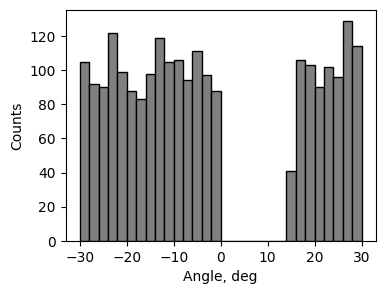

In [14]:
fig = plt.figure(figsize=(4,3))
_ = plt.hist(angles_train, bins=30, range=(-30,30), edgecolor='black', color='grey')
plt.xlabel('Angle, deg')
plt.ylabel('Counts')

In [15]:
ws = 48
data_dim = (ws, ws)
model = dkiVAE(data_dim, 2, dkl_scale_factor=20)
trainer = JointModelTrainer(model)
dataloader = init_dataloader(cards_train.reshape(-1, ws* ws), angles_train.to(dtype=torch.float32), batch_size=100)

In [16]:
figs = []
for e in range(1500):
    trainer.step(dataloader, train_vae=True)
    trainer.print_statistics()
    ##verbose
    # if (e+1) % 50 == 0:
    #     model.manifold2d(d=12)

    #     z_loc, _ = model.encode(cards_all.reshape(-1, ws* ws))

    #     fig,ax = plt.subplots(1,2, figsize=(10,4))

    #     im = ax[0].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=labels_all, cmap='jet')
    #     cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
    #     im = ax[1].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=angles_all, cmap='jet')
    #     cbar = fig.colorbar(im, ax=ax[1], shrink=.8)

    #     for _ in ax:
    #       _.set_xlabel('$z_1$', fontsize=14)
    #       _.grid()

    #     ax[0].set_title('Suits')
    #     ax[1].set_title('Angles')
    #     ax[0].set_ylabel('$z_2$', fontsize=14)

    #     plt.show()
    #     figs.append(fig)

Epoch: 1 Training loss: 20477121.2056
Epoch: 2 Training loss: 12355092.0567
Epoch: 3 Training loss: 6546126.4365
Epoch: 4 Training loss: 7710594.7395
Epoch: 5 Training loss: 2819895.9931
Epoch: 6 Training loss: 2182125.0604
Epoch: 7 Training loss: 1913887.2688
Epoch: 8 Training loss: 2059728.1208
Epoch: 9 Training loss: 2896021.9183
Epoch: 10 Training loss: 4183629.5485
Epoch: 11 Training loss: 1178854.6515
Epoch: 12 Training loss: 1107137.1432
Epoch: 13 Training loss: 1058498.3726
Epoch: 14 Training loss: 1008895.7610
Epoch: 15 Training loss: 1062525.9304
Epoch: 16 Training loss: 1066843.0449
Epoch: 17 Training loss: 1315527.6182
Epoch: 18 Training loss: 1110166.3313
Epoch: 19 Training loss: 1313937.2520
Epoch: 20 Training loss: 921404.5888
Epoch: 21 Training loss: 954084.8315
Epoch: 22 Training loss: 771864.4435
Epoch: 23 Training loss: 787471.8714
Epoch: 24 Training loss: 684869.9257
Epoch: 25 Training loss: 707697.9484
Epoch: 26 Training loss: 636729.9698
Epoch: 27 Training loss: 6

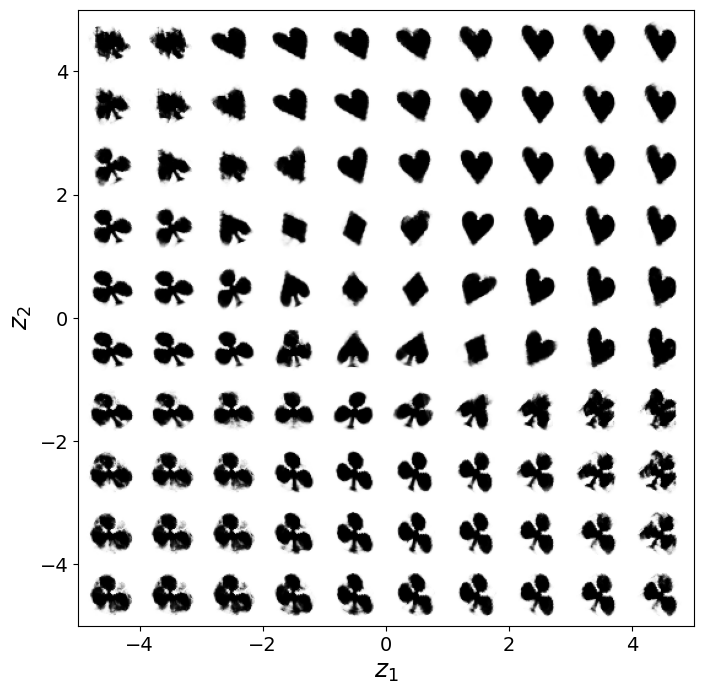

In [17]:
z_grid, _ = generate_latent_grid(d=150, z_coord=[-5, 5, -5, 5])
mean_m, cov_m = model.get_mvn_posterior(z_grid)

mf = model.manifold2d(d=10, cmap='binary', z_coord=[-5,5,-5,5], dpi=50);
mf_np = rearrange_manifold(mf)

In [18]:
test_mean_m, test_cov_m = model.dkl_predict(cards_test.reshape(-1, ws* ws))

<ipython-input-19-4b085abb57a3>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  scatter = ax[1,0].scatter(z_loc[indices, -2].numpy(), z_loc[indices, -1].numpy(),


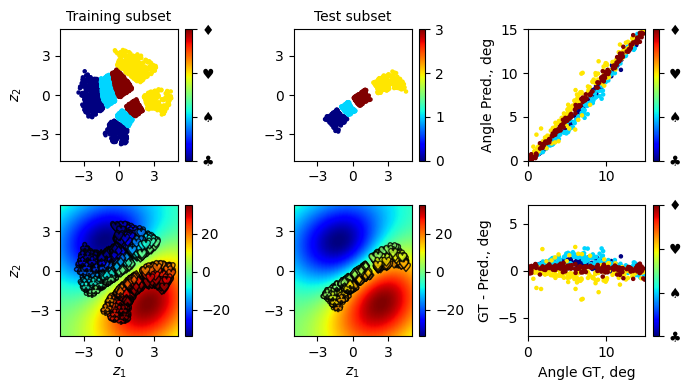

In [19]:
suits = ['♣', '♠', '♥', '♦',]
suit_markers = {0: '♣', 1: '♠', 2: '♥', 3: '♦'}

fig, ax = plt.subplots(2,3, figsize=(7, 4))

z_loc, _ = model.encode(cards_train.reshape(-1, ws* ws))

im = ax[0,0].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=labels_train, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0,0])
cbar.set_ticks(np.linspace(0, 3, len(suits)))  # Set positions of labels
cbar.set_ticklabels(suits)
ax[0,0].set_title('Training subset', fontsize=10)

im = ax[1,0].scatter(z_grid[:, -2], z_grid[:, -1], s=5, c=mean_m, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1,0])
for suit_id, suit_marker in suit_markers.items():
  indices = np.where(labels_train == suit_id)
  scatter = ax[1,0].scatter(z_loc[indices, -2].numpy(), z_loc[indices, -1].numpy(),
             label=suit_marker, s=40, alpha=0.8, edgecolors='black',
             marker='$' + suit_marker + '$',
             c = angles_train[indices],
             vmin=-30,
             vmax=30,
             cmap='jet')  # Use Unicode marker as custom text

im = ax[1,1].scatter(z_grid[:, -2], z_grid[:, -1], s=5, c=mean_m, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1,1])

z_loc, _ = model.encode(cards_test.reshape(-1, ws* ws))


im = ax[0,1].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=labels_test, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0,1])
cbar.set_ticks(np.linspace(0, 3, len(suit_markers)))  # Set positions of labels
cbar.set_ticklabels(suit_markers)

for suit_id, suit_marker in suit_markers.items():
  indices = np.where(labels_test == suit_id)
  scatter = ax[1,1].scatter(z_loc[indices, -2].numpy(), z_loc[indices, -1].numpy(),
             label=suit_marker, s=40, alpha=0.8, edgecolors='black',
             marker='$' + suit_marker + '$',
             c = angles_test[indices],
             vmin=-30,
             vmax=30,
             cmap='jet')  # Use Unicode marker as custom text

ax[0,1].set_title('Test subset', fontsize=10)

im = ax[0,2].scatter(angles_test, test_mean_m,  c=labels_test, cmap='jet', s=5)
cbar = fig.colorbar(im, ax=ax[0,2])
cbar.set_ticks(np.linspace(0, 3, len(suits)))  # Set positions of labels
cbar.set_ticklabels(suits)

ax[1,2].scatter(angles_test,  angles_test - test_mean_m, c=labels_test, cmap='jet', s=5,)
cbar = fig.colorbar(im, ax=ax[1,2])
cbar.set_ticks(np.linspace(0, 3, len(suits)))  # Set positions of labels
cbar.set_ticklabels(suits)

for i,_ in enumerate(ax.flatten()):
  if (i != 2) and (i !=5):
    pass
    _.set_xlim(-5,5)
    _.set_ylim(-5,5)
    _.set_xticks([-3,0,3])
    _.set_yticks([-3,0,3])

ax[0,2].set_xlim(0,15)
ax[1,2].set_xlim(0,15)
ax[0,2].set_ylim(0,15)
ax[1,2].set_ylim(-7,7)

ax[0,0].set_ylabel('$z_2$', fontsize=10)
ax[1,0].set_ylabel('$z_2$', fontsize=10)
ax[1,0].set_xlabel('$z_1$', fontsize=10)
ax[1,1].set_xlabel('$z_1$', fontsize=10)
ax[1,2].set_xlabel('Angle GT, deg', fontsize=10)
ax[1,2].set_ylabel('GT - Pred., deg', fontsize=10)
ax[0,2].set_ylabel('Angle Pred., deg', fontsize=10)
plt.tight_layout()

#fig.savefig('DKLVAE_latent_space_gap_sf20.jpg', dpi=300, bbox_inches='tight')

In [21]:
def r2_score(y_true, y_pred):
    """Compute the R-squared (coefficient of determination) score."""
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def rmse(y_true, y_pred):
    """Compute the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_ssim(image1: np.ndarray, image2: np.ndarray) -> float:
    """Compute the Structural Similarity Index (SSIM) between two images."""
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    ssim1 = np.array([])
    # Compute SSIM
    for i in range(len(image1)):
      ssim_score, _ = ssim(image1[i], image2[i], full=True, data_range=image2[i].max() - image2[i].min())
      ssim1 = np.append(ssim1, ssim_score)
    return ssim1

In [22]:
for i in suit_markers:
  print(suit_markers[i])
  print(round(rmse(np.array(test_mean_m[labels_test==i]), np.array(angles_test[labels_test==i])),2))
  print(round(r2_score(np.array(test_mean_m[labels_test==i]), np.array(angles_test[labels_test==i])),2))

print('\n')
print(round(rmse(np.array(test_mean_m), np.array(angles_test)),2))
print(round(r2_score(np.array(test_mean_m), np.array(angles_test)),2))

♣
0.62
0.98
♠
0.99
0.96
♥
0.76
0.97
♦
0.37
0.99


0.71
0.98


Text(0.5, 1.0, 'Max. SSIM')

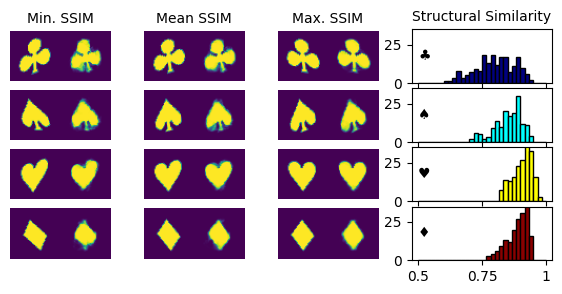

In [23]:
v, U = model.encode(cards_test.reshape(-1, ws* ws))
d = model.decode(v)
ssim_scores = compute_ssim(cards_test.numpy(), d.reshape(-1, ws, ws).numpy())

colors = ['navy', 'cyan', 'yellow', 'darkred',]

fig, axes = plt.subplots(4, 4, figsize=(7, 3), gridspec_kw={'width_ratios': [0.5, 0.5, 0.5, 0.7]})
fig.subplots_adjust(hspace=0.1, wspace=.3)

for i, label in enumerate([0, 1, 2, 3]):
    axes[i,-1].hist(ssim_scores[labels_test == label], bins=30, range=[0.5, 1], color=colors[i], edgecolor='black', linewidth=1)
    axes[i,-1].set_ylim(0,35)
    axes[i,-1].set_yticks([0,25])
    axes[i,-1].set_yticklabels([0,25],fontsize=10)
    axes[i,-1].text(0.5, 15, suit_markers[i])
    axes[i,-1].set_xticks([.5,.75,1])
    axes[i,-1].set_xticklabels([])

axes[0,-1].set_title("Structural Similarity", fontsize=10)
axes[-1,-1].set_xticks([.5,.75,1])
axes[-1,-1].set_xticklabels([.5,.75,1],fontsize=10)

for i, ax_ in enumerate(axes[:,0]):
  ii = np.argmin(ssim_scores[labels_test==i])
  img = np.hstack([cards_test[labels_test==i][ii], d[labels_test==i][ii].reshape(ws, ws)])
  ax_.imshow(img)
  ax_.axis('off')

for i, ax_ in enumerate(axes[:,1]):
  ii = np.argmin(abs(ssim_scores[labels_test==i] - np.mean(ssim_scores[labels_test==i])))
  img = np.hstack([cards_test[labels_test==i][ii], d[labels_test==i][ii].reshape(ws, ws)])
  ax_.imshow(img)
  ax_.axis('off')

for i, ax_ in enumerate(axes[:,2]):
  ii = np.argmax(ssim_scores[labels_test==i])
  img = np.hstack([cards_test[labels_test==i][ii], d[labels_test==i][ii].reshape(ws, ws)])
  ax_.imshow(img)
  ax_.axis('off')

axes[0,0].set_title("Min. SSIM", fontsize=10)
axes[0,1].set_title("Mean SSIM", fontsize=10)
axes[0,2].set_title("Max. SSIM", fontsize=10)


#fig.savefig('ssim_cards.jpg', dpi=300, bbox_inches='tight')

# 4. DKL scale factor variation

In [24]:
dkl_scale = [0.1, 1, 10, 20, 30, 50, 100, 1000, 100000]

In [25]:
models_vaedkl = {}

ws = 48
data_dim = (ws, ws)

for dkl_s in dkl_scale:
  print('dkl_scale ', dkl_s)
  model = dkiVAE(data_dim, 2, dkl_scale_factor=dkl_s)
  trainer = JointModelTrainer(model)
  dataloader = init_dataloader(cards_train.reshape(-1, ws* ws), angles_train.to(dtype=torch.float32), batch_size=100)

  for e in range(1500):
    trainer.step(dataloader, train_vae=True)

  models_vaedkl[dkl_s] = model

dkl_scale  0.1
dkl_scale  1
dkl_scale  10
dkl_scale  20
dkl_scale  30
dkl_scale  50
dkl_scale  100
dkl_scale  1000
dkl_scale  100000


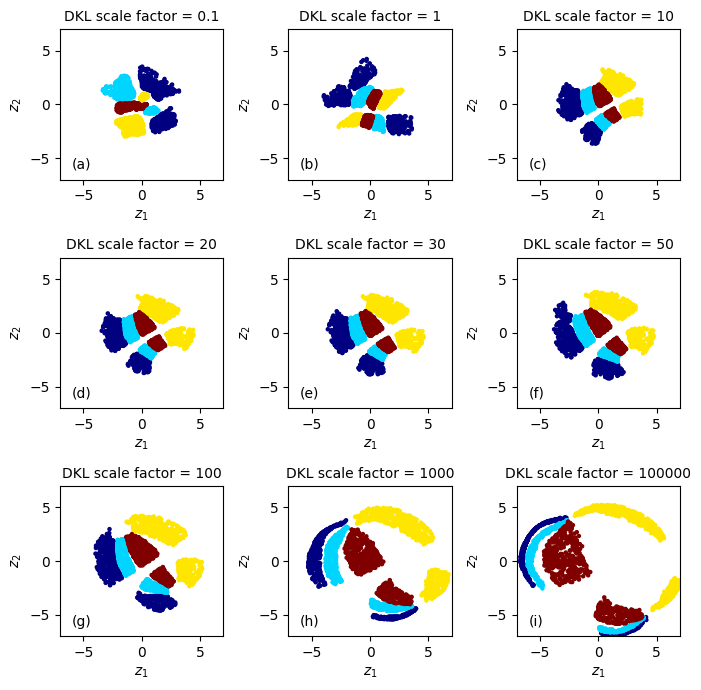

In [30]:
letters = ['a', 'b', 'c',
           'd', 'e', 'f',
           'g', 'h', 'i']

fig, ax = plt.subplots(3,3, figsize=(7,7))
axs = ax.flatten()
for i,k in enumerate(models_vaedkl):
  z_loc, _ = models_vaedkl[k].encode(cards_train.reshape(-1, ws* ws))

  im = axs[i].scatter(z_loc[:, -2], z_loc[:, -1], s=5, c=labels_train, cmap='jet')
  axs[i].set_title(f'DKL scale factor = {k}', fontsize=10)

for i,_ in enumerate(ax.flatten()):
  _.set_xlim(-7,7)
  _.set_ylim(-7,7)
  _.set_ylabel('$z_2$')
  _.set_xlabel('$z_1$')
  _.text(-6, -6, f'({letters[i]})', fontsize=10)

plt.tight_layout()
#fig.savefig('cards_train_dset_dkl_coef.jpg', dpi=300, bbox_inches='tight')

In [27]:
dkl_coef = []
rmse_dkl_coef = []
r2_score_dkl_coef = []
ssim_dkl_coef = []

for i,k in enumerate(models_vaedkl):
  test_mean_m, test_cov_m = models_vaedkl[k].dkl_predict(cards_test.reshape(-1, ws* ws))

  rrmse = round(rmse(np.array(test_mean_m), np.array(angles_test)),2)
  rr2_score = round(r2_score(np.array(test_mean_m), np.array(angles_test)),2)

  dkl_coef.append(k)
  rmse_dkl_coef.append(rrmse)
  r2_score_dkl_coef.append(rr2_score)

  v, U = models_vaedkl[k].encode(cards_test.reshape(-1, ws* ws))
  d = models_vaedkl[k].decode(v)

  ssim_scores = compute_ssim(cards_test.numpy(), d.reshape(-1,ws,ws).numpy())
  ssim_dkl_coef.append(ssim_scores)

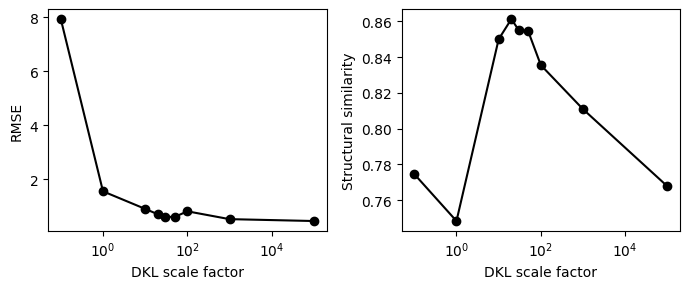

In [28]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].plot(dkl_coef, rmse_dkl_coef , 'o-', c='black')
ax[0].set_xscale('log')
ax[0].set_ylabel('RMSE')

ax[1].plot(dkl_coef, np.array(ssim_dkl_coef).mean(1) , 'o-', c='black')
ax[1].set_xscale('log')
ax[1].set_ylabel('Structural similarity')

for _ in ax:
  _.set_xlabel('DKL scale factor')

plt.tight_layout()
#fig.savefig('estimations_dset_dkl_coef.jpg', dpi=300, bbox_inches='tight')

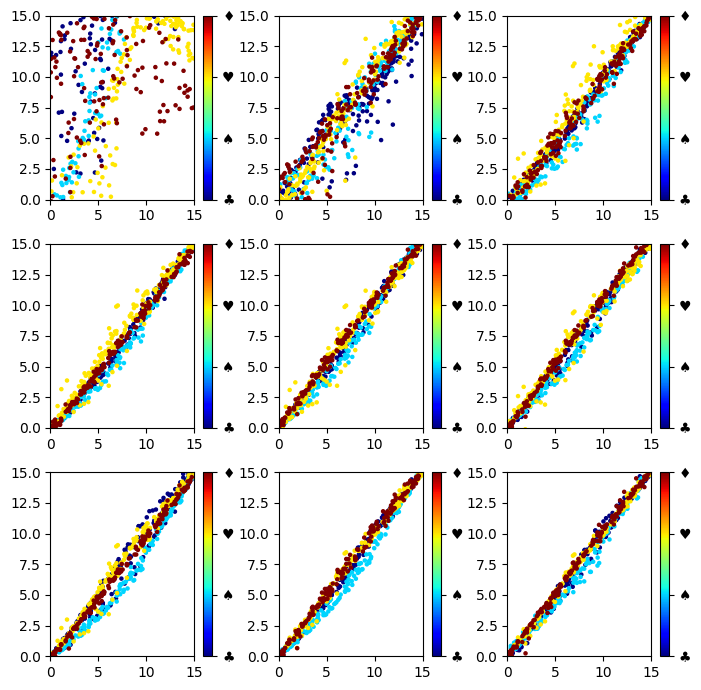

In [29]:
fig, ax = plt.subplots(3,3, figsize=(7,7))
axs = ax.flatten()
for i,k in enumerate(models_vaedkl):
  test_mean_m, test_cov_m = models_vaedkl[k].dkl_predict(cards_test.reshape(-1, ws* ws))

  im = axs[i].scatter(angles_test, test_mean_m,  c=labels_test, cmap='jet', s=5)
  cbar = fig.colorbar(im, ax=axs[i])
  cbar.set_ticks(np.linspace(0, 3, len(suits)))  # Set positions of labels
  cbar.set_ticklabels(suits)

for _ in ax.flatten():
  _.set_xlim(0,15)
  _.set_ylim(0,15)

plt.tight_layout()